In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import yaml
import numpy as np
from copy import deepcopy

# What and why?

Per default the pycomplexes convert tool assumes the pH in your simulation to be pH = 7.0.
We provided a tool (**ph**) to change the charges of your coarse-grained in accordance to pH values different from 7.0.
We assume the amino acids to be quasi free and apply the *Henderson-Hasselbalch* equation. The **ph** tool applies changes to
an existing cplx file.

# Change sidechain charges in cplx structure file

We prepared an artificial structure file for this tutorial. 
We can make use of the command line to quickly change the charges in the file in accordance to a certain pH. Let's prepare structures at a pH = 4

In [3]:
!pycomplexes ph test.cplx 4 -o pH4.cplx

Optionally to the CLI tool you can also directly make use of the pycomplexes python library. As an example we create structures for a pH 4 to 10

In [4]:
from pycomplexes import ph

We load the prepared structure file:

In [5]:
with open("test.cplx") as f:
    cplx_struct = yaml.safe_load(f)

We create structures for different pHs:

In [6]:
pHs = np.arange(4, 10, 0.5)
modified_cplx_structs = [deepcopy(ph.change_charges(cplx_struct, ph=pH)) for pH in pHs]

And write the structures into separate cplx files

In [7]:
for pH, modified_struc in zip(pHs, modified_cplx_structs):
    fname = "pH{}.cplx".format(pH)
    with open(fname, "w") as f:
        yaml.dump(modified_struc, f)

We wrote a couple of files now. Check yourself.

Let's see how the charges in the structure files have changed.
Here we specifically look at the changed charges for a single HIS in the cplx.

In [8]:
top_idx = 1
domain_idx = 3
charges = []
for pH, modified_struc in zip(pHs, modified_cplx_structs):
    resname = modified_struc["topologies"][top_idx]["domains"][domain_idx]["beads"][0]
    charge = modified_struc["topologies"][top_idx]["domains"][domain_idx]["charges"][0]
    charges.append(charge)

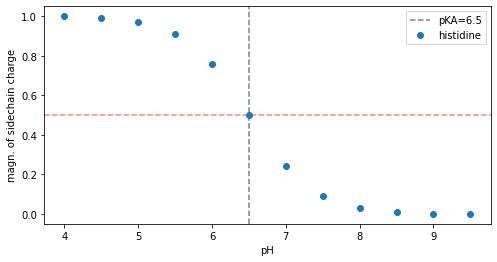

In [9]:
f,axs = plt.subplots(figsize=plt.figaspect(.5))
axs.axhline( .5, c="r", ls="--", alpha=.5)
axs.axvline(6.5, c="k", ls="--", alpha=.5, label="pKA=6.5")
axs.plot(pHs, charges, "o", label="histidine")
axs.set(xlabel="pH",
        ylabel="magn. of sidechain charge")
axs.legend();

Try other residues in the example file and see how the charges of other residue types changes with the pH.

# Use custom pKA values for the residues

In [10]:
# lets make a copy of the default pKA values
charged_sidechains = deepcopy(ph.CHARGED_SIDECHAINS)

In [11]:
# default pKA values and information, whether the sidechain is acidic or basic (charge is -1 or +1)
for resname, subdict in charged_sidechains.items():
    print("residue name: {}".format(resname))
    for key, val in subdict.items():
        print("\t{}:\t {:>4.1f}".format(key, val))

residue name: ASP
	charge:	 -1.0
	pK:	  3.8
residue name: HIS
	charge:	  1.0
	pK:	  6.5
residue name: LYS
	charge:	  1.0
	pK:	 10.5
residue name: GLU
	charge:	 -1.0
	pK:	  4.5
residue name: ARG
	charge:	  1.0
	pK:	 12.5
residue name: TYR
	charge:	 -1.0
	pK:	 10.0


We want to apply a pKA-value of 6.0 to residues of type histidine, which is different than the default value. 
Therefore, we change the dictionary with the pKA information in the following way. 
We leave all other pKAs untouched. 

In [12]:
charged_sidechains["HIS"]["pK"] = 6.0

We redo the procedure above with the modified values.

In [13]:
modified_cplx_structs = [deepcopy(ph.change_charges(cplx_struct, ph=pH, charged_sidechains=charged_sidechains)) for pH in pHs]

top_idx = 1
domain_idx = 3
charges_new = []
for pH, modified_struc in zip(pHs, modified_cplx_structs):
    resname = modified_struc["topologies"][top_idx]["domains"][domain_idx]["beads"][0]
    charge = modified_struc["topologies"][top_idx]["domains"][domain_idx]["charges"][0]
    charges_new.append(charge)

We visualize the change of the titration curve:

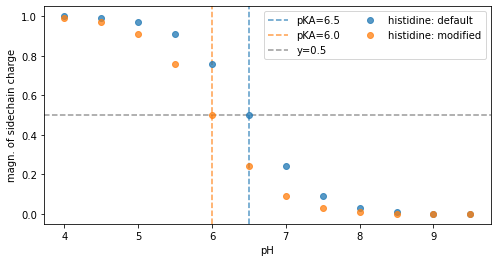

In [14]:
f,axs = plt.subplots(figsize=plt.figaspect(0.5))
axs.axvline(6.5, c="C0", ls="--", alpha=.75, label="pKA=6.5")
axs.axvline(6.0, c="C1", ls="--", alpha=.75, label="pKA=6.0")
axs.axhline( .5, c="k", ls="--", alpha=.4, label="y=0.5")
axs.plot(pHs, charges, "o", label="histidine: default", alpha=.75, c="C0")
axs.plot(pHs, charges_new, "o", label="histidine: modified", alpha=.75, c="C1")
axs.set(xlabel="pH",
        ylabel="magn. of sidechain charge")
axs.legend(ncol=2);

We can also save the dictionary `charged_sidechains` in a file and use custom pKA values with the command-line tool with the flag: `-pk`